# Imports and Preparing the data of behavior.tsv and news.tsv #

In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import IncrementalPCA, PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage


# Load the data
base_path = Path.cwd() / 'data'
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Preprocessing with Data Cleaning Remove duplicates and Text cleaning

In [2]:
# Data Cleaning
# Check if attributes such as Category, Subcategory, Title, and Abstract in news.tsv are complete.
# Remove news items with many missing values or replace them with:
# Category: unknown
# Subcategory: general
# Title and Abstract: a placeholder text like "Missing Data."
# For behaviors.tsv, remove users with missing or empty history.
news.fillna({'category': 'unknown', 'subcategory': 'general', 'title': 'Missing Title', 'abstract': 'Missing Abstract'}, inplace=True)
news.dropna(subset=['category', 'subcategory', 'title', 'abstract'], inplace=True)
behaviors.dropna(subset=['history', 'impressions'], inplace=True)

# Remove duplicates
# Remove news items in news.tsv that have the same values for Title and Abstract.
# Remove duplicate impressions (Impression ID) in behaviors.tsv
news.drop_duplicates(subset=['title', 'abstract'], inplace=True)
behaviors.drop_duplicates(subset=['impression_id'], inplace=True)

# Text cleaning
# Break down Title and Abstract into tokens:
# Remove special characters, numbers, and HTML.
# Convert all words to lowercase.
# Remove stopwords (e.g., using nltk or spacy).
# Perform lemmatization to reduce words to their base form.
def clean_text(text):
    """Clean text by removing special characters, numbers, and converting to lowercase."""
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'s", " is", text)
    
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text.lower()

def remove_stopwords_and_lemmatize(text):
    """Remove stopwords and perform basic stemming/lemmatization."""
    stopwords = set([
        'the', 'and', 'is', 'in', 'to', 'of', 'a', 'an', 'on', 'for', 'with', 'as', 'by', 'at', 'from', 'this',
        'that', 'it', 'or', 'but', 'not', 'be', 'are', 'was', 'were', 'can', 'will', 'would', 'should', 'has', 'have',
        'had', 'do', 'does', 'did', 'which', 'if', 'then', 'than', 'so', 'such', 'there', 'about', 'into', 'over', 'after'
    ])
    words = text.split()
    # Basic lemmatization (remove plural "s")
    lemmatized = [word[:-1] if word.endswith('s') else word for word in words]  
    return " ".join(word for word in lemmatized if word not in stopwords)

def preprocess_text(text):
    """Full preprocessing pipeline: clean text, remove stopwords, and lemmatize."""
    cleaned_text = clean_text(text)
    return remove_stopwords_and_lemmatize(cleaned_text)

def preprocess_text_parallel(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    return processed_texts

# Clean Title and Abstract
news['clean_title'] = preprocess_text_parallel(news['title'])
news['clean_abstract'] = preprocess_text_parallel(news['abstract'])

# Data Preparation with TF-IDF, One-hot and PCA

In [3]:
#TF-IDF
# Convert clean_title and clean_abstract into numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_title = tfidf_vectorizer.fit_transform(news['clean_title'])
tfidf_abstract = tfidf_vectorizer.fit_transform(news['clean_abstract'])

# Combine sparse matrices
news_features = hstack([tfidf_title, tfidf_abstract])

# One-hot encode categories and subcategories
category_encoded = pd.get_dummies(news['category'])
subcategory_encoded = pd.get_dummies(news['subcategory'])

# Combine categorical and TF-IDF features
final_features = hstack([news_features, category_encoded.values, subcategory_encoded.values])

# PCA for faster processing instead of t-SNE for better visualization
pca = IncrementalPCA(n_components=50, batch_size=1000)
reduced_features = pca.fit_transform(news_features)

# Elbow method to get best cluster amount

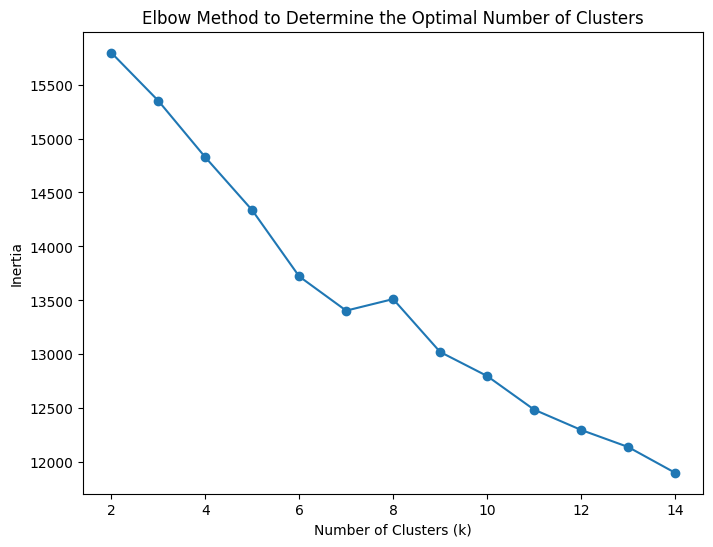

In [4]:
# Elbow method
inertia_values = []
cluster_range = range(2, 15)  # Test cluster numbers between 2 and 14

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    inertia_values.append(kmeans.inertia_)

# Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine the Optimal Number of Clusters')
plt.show()

# Silhouette analysis to get best cluster amount

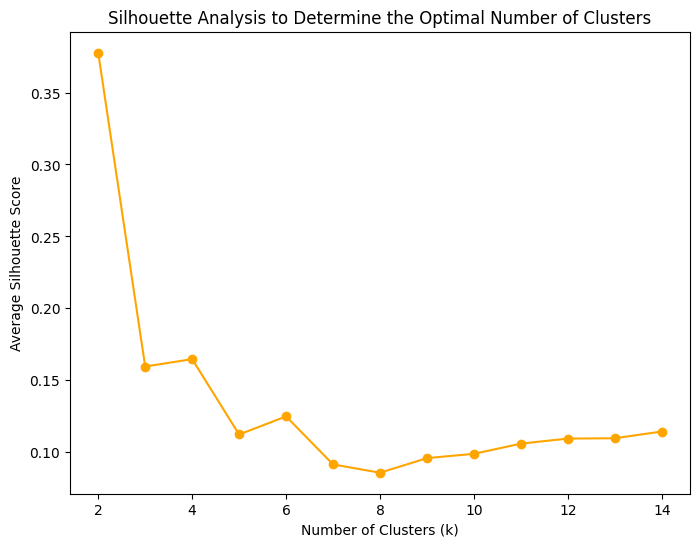

In [5]:
# Silhouette analysis
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis to Determine the Optimal Number of Clusters')
plt.show()

# Hierarchical Clustering with Dendrogram

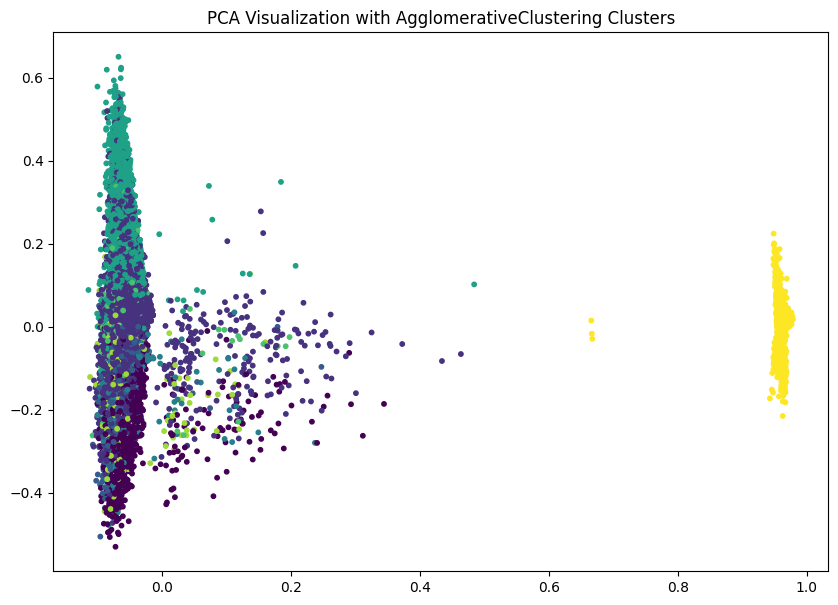

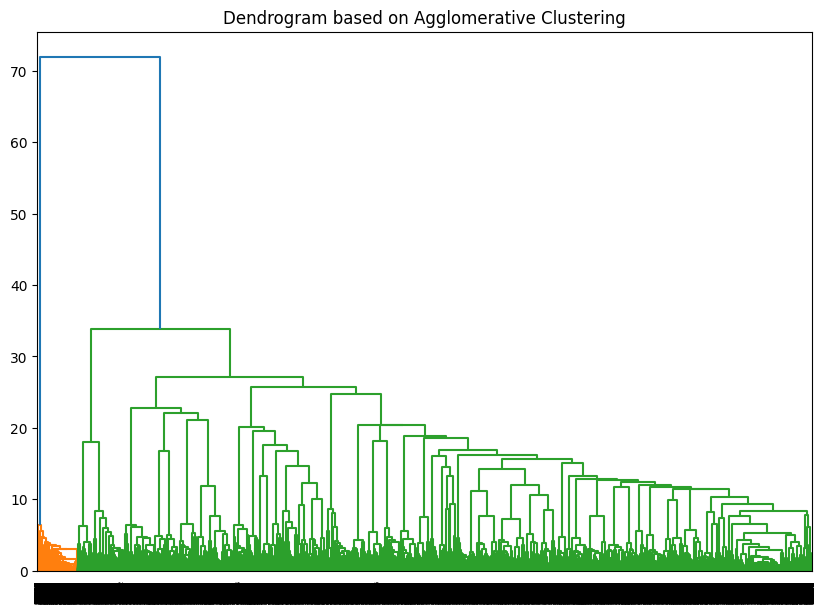

In [10]:
optimal_k = 8

agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels = agglo.fit_predict(reduced_features)

# PCA for Visualization of Clusters (Agglomerative Clustering)
pca_vis = PCA(n_components=2)
pca_features = pca_vis.fit_transform(reduced_features)

# Plot PCA visualization
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f'PCA Visualization with AgglomerativeClustering Clusters')
plt.show()

# If you still want a dendrogram like in scipy, you can visualize the clustering results
# by creating a dendrogram based on AgglomerativeClustering distances:
Z = linkage(reduced_features, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram based on Agglomerative Clustering')
plt.show()

# KMeans Visualization with PCA

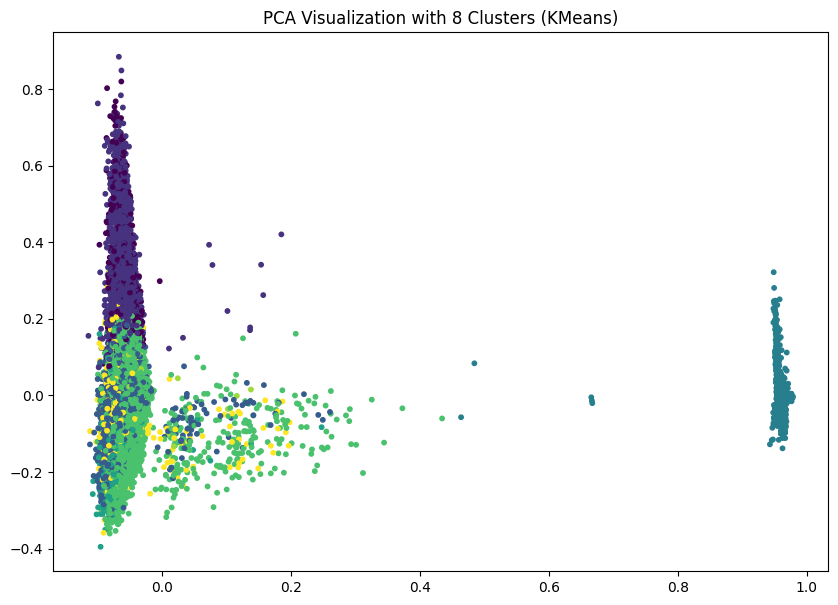

In [6]:
# Clustering with MiniBatchKMeans
optimal_k = 8

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
news['cluster'] = kmeans.fit_predict(reduced_features)

# PCA for Visualization
pca_vis = IncrementalPCA(n_components=2)
pca_features = pca_vis.fit_transform(reduced_features)

# PCA Visualization
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f'PCA Visualization with {optimal_k} Clusters (KMeans)')
plt.show()


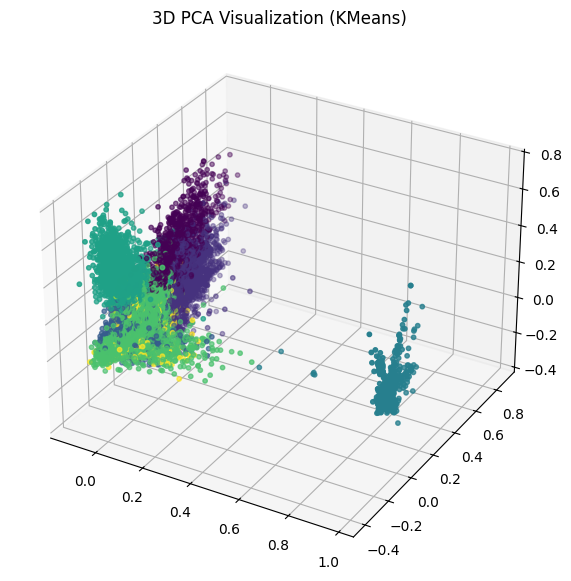

In [7]:
# PCA mit 3 Dimensionen
pca_3d = IncrementalPCA(n_components=3)
pca_features_3d = pca_3d.fit_transform(reduced_features)

# 3D-Visualisierung
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_features_3d[:, 0], 
    pca_features_3d[:, 1], 
    pca_features_3d[:, 2], 
    c=news['cluster'], cmap='viridis', s=10
)

ax.set_title('3D PCA Visualization (KMeans)')
plt.show()


C:\Users\stefa\PycharmProjects\CTDS\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


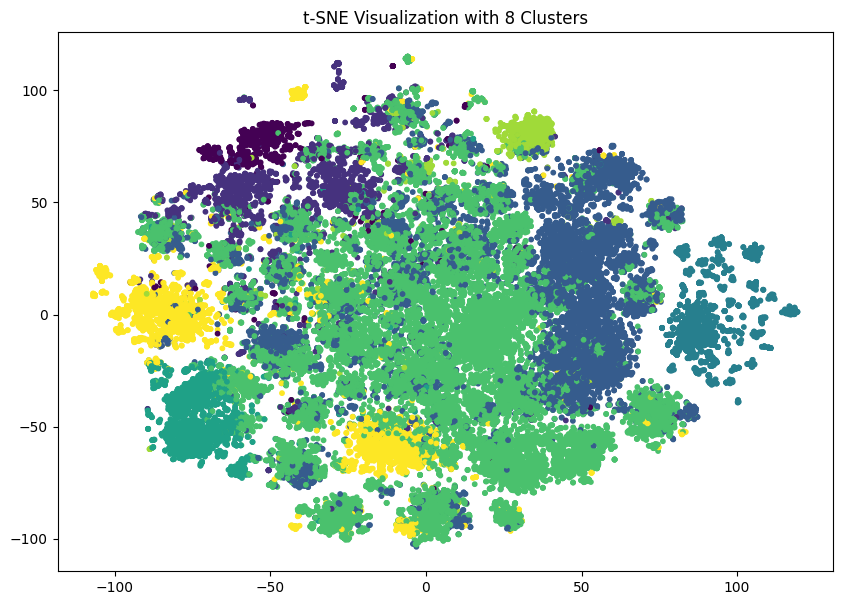

In [8]:
# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_features = tsne.fit_transform(reduced_features)

# t-SNE Visualization
plt.figure(figsize=(10, 7))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f't-SNE Visualization with {optimal_k} Clusters')
plt.show()


# DBSCAN Clustering

In [11]:
# Check the number of rows in the news DataFrame
num_rows = news.shape[0]
print(f"The number of rows in the news DataFrame is: {num_rows}")


The number of rows in the news DataFrame is: 50669


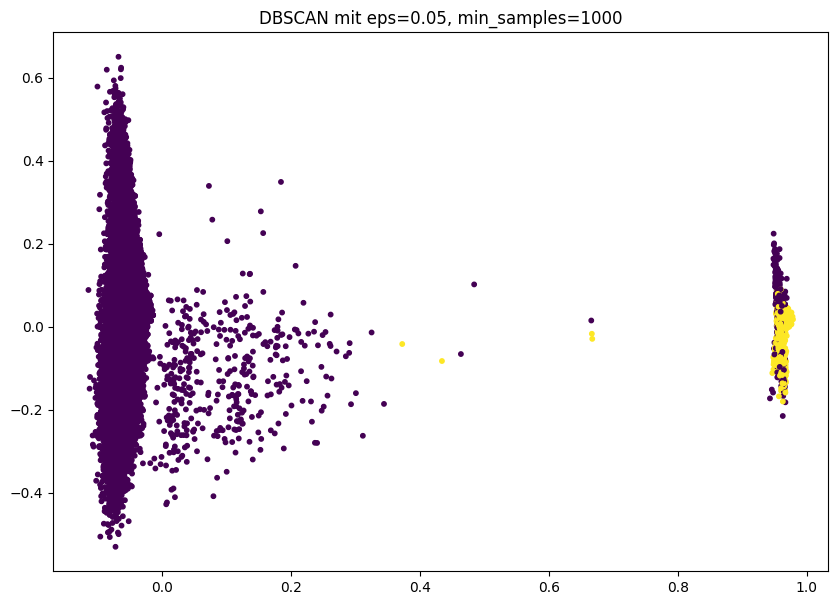

Parameter eps=0.05, min_samples=1000
{np.int64(-1): np.int64(48449), np.int64(0): np.int64(2220)}

----------------------------------------



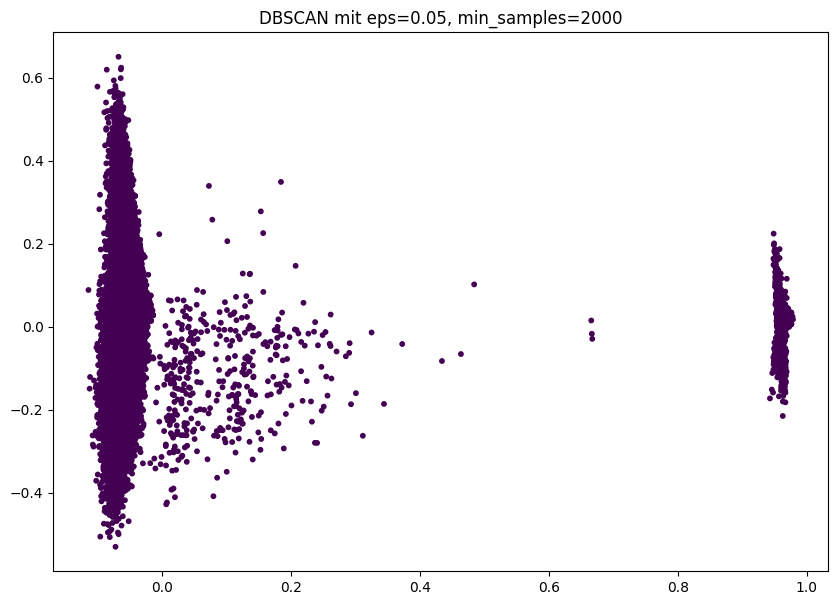

Parameter eps=0.05, min_samples=2000
{np.int64(-1): np.int64(50669)}

----------------------------------------



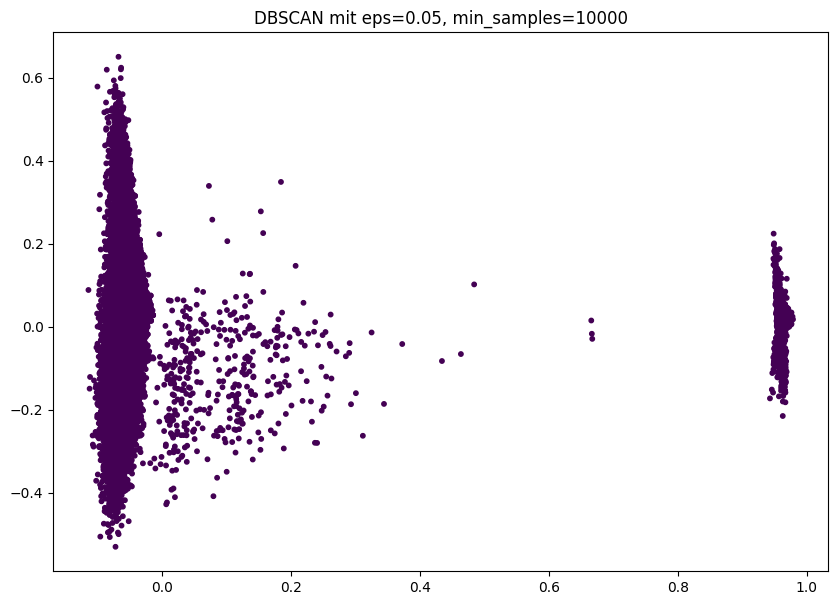

Parameter eps=0.05, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



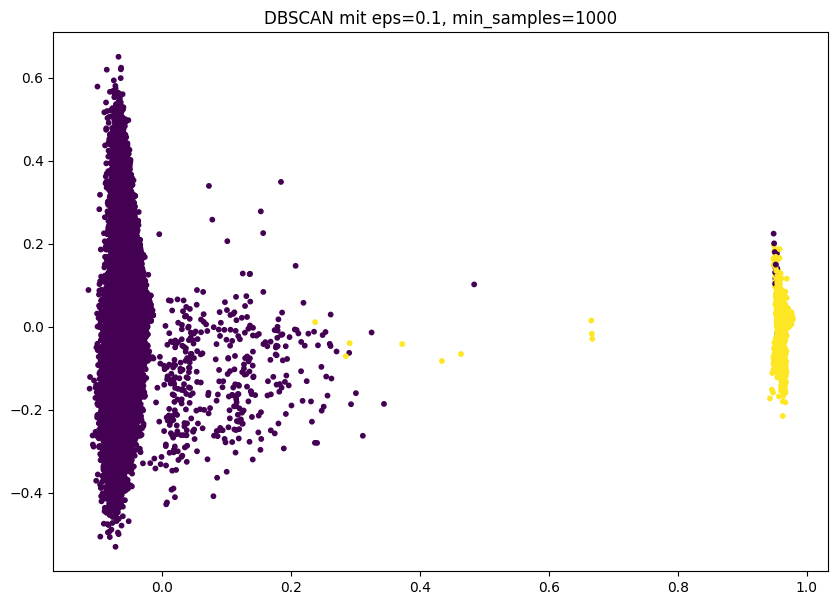

Parameter eps=0.1, min_samples=1000
{np.int64(-1): np.int64(48027), np.int64(0): np.int64(2642)}

----------------------------------------



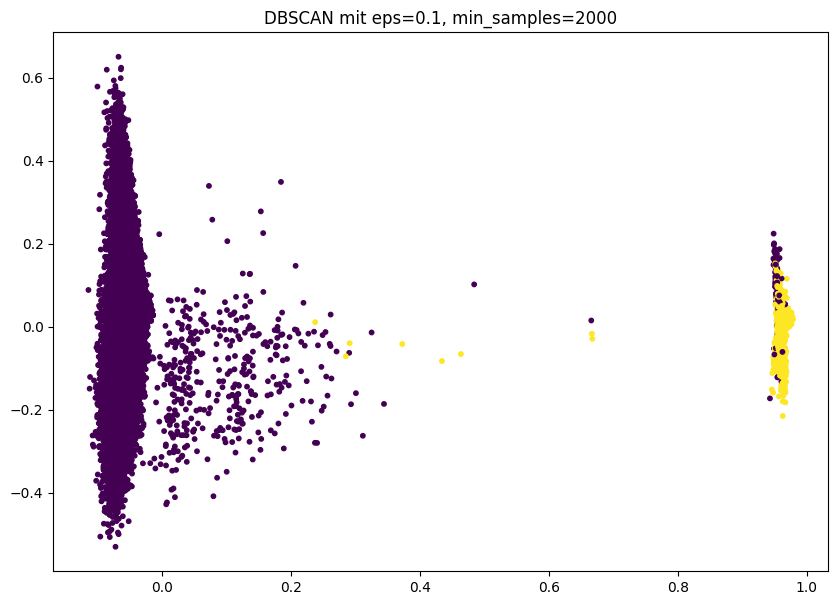

Parameter eps=0.1, min_samples=2000
{np.int64(-1): np.int64(48159), np.int64(0): np.int64(2510)}

----------------------------------------



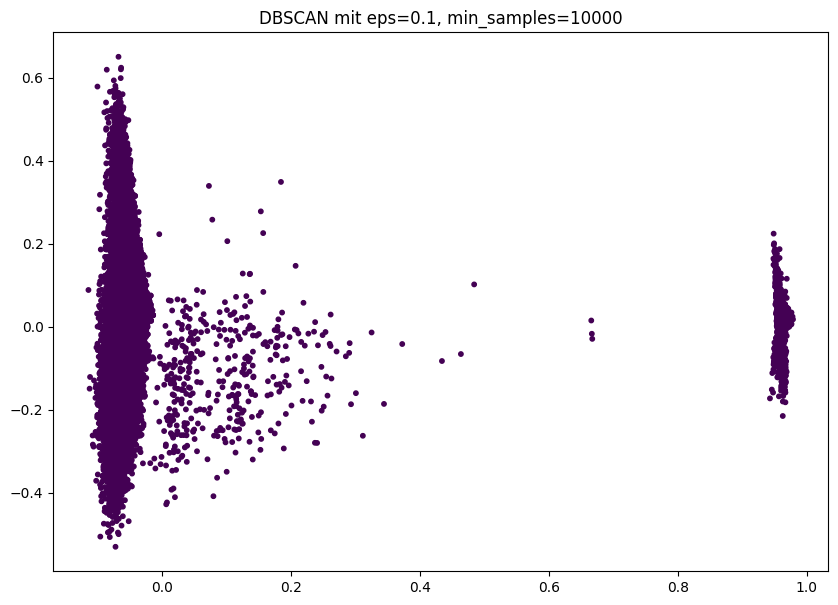

Parameter eps=0.1, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



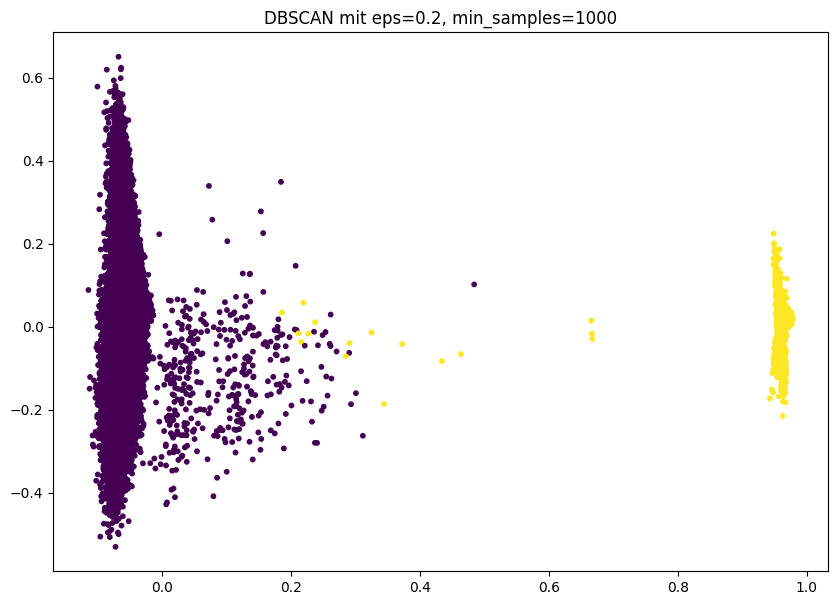

Parameter eps=0.2, min_samples=1000
{np.int64(-1): np.int64(47998), np.int64(0): np.int64(2671)}

----------------------------------------



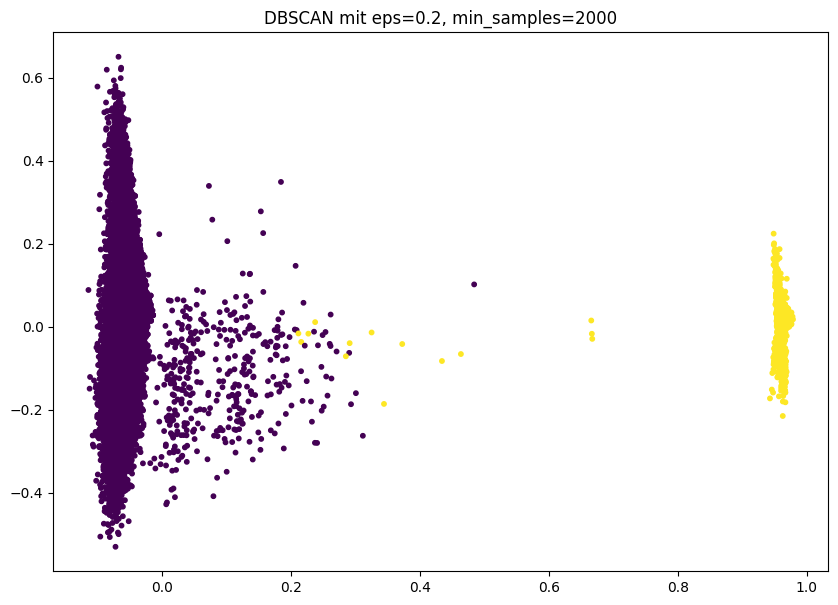

Parameter eps=0.2, min_samples=2000
{np.int64(-1): np.int64(48000), np.int64(0): np.int64(2669)}

----------------------------------------



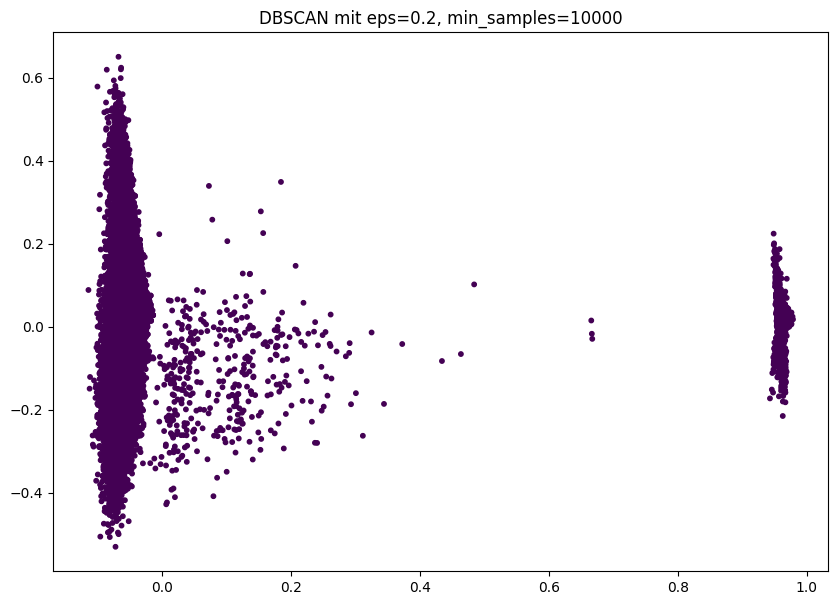

Parameter eps=0.2, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



In [14]:
# DBSCAN Clustering
eps_values = [0.05, 0.1, 0.2]
min_samples_values = [1000, 2000, 10000]

# Small eps values (like 0.05) lead to many small, dense clusters and a high number of outliers, which might be too restrictive for your dataset.
# Medium eps values (e.g., 0.1) offer a better balance and create several larger clusters. This might be a better choice as it results in fewer outliers and more differentiated clusters.
# Large eps values (e.g., 0.2) tend to group most data points into one cluster, indicating that eps=0.2 is too large to form meaningful clusters.

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(reduced_features)

        plt.figure(figsize=(10, 7))
        plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
        plt.title(f'DBSCAN mit eps={eps}, min_samples={min_samples}')
        plt.show()

        unique, counts = np.unique(labels, return_counts=True)
        print(f'Parameter eps={eps}, min_samples={min_samples}')
        print(dict(zip(unique, counts)))
        print("\n" + "-"*40 + "\n")

# Elements an Categories per Clustering

In [9]:
# KMeans

# Count the number of articles in each cluster
cluster_counts = news['cluster'].value_counts().sort_index()

# Initialize dictionaries to store cluster information
cluster_examples = {}
cluster_categories = {}

# Iterate through each cluster
for cluster_id in sorted(news['cluster'].unique()):
    cluster_data = news[news['cluster'] == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per cluster:")
print(cluster_counts)

for cluster_id in cluster_examples:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories[cluster_id])


Number of articles per cluster:
cluster
0     1014
1     3219
2    10351
3     2660
4     2470
5    26131
6      925
7     3899
Name: count, dtype: int64

Cluster 0:
Examples:
                                                 title      category
26   25 Last-Minute Ideas That Will Absolutely Save...  foodanddrink
34   20 Must-Try Gravy Recipes for Your Thanksgivin...  foodanddrink
52   I'm Sorry, But Please Do Not Put Your Purse On...        health
57   100 Genius Tips that Will Make Your Holidays S...  foodanddrink
70   16 major chains where you can buy plant-based ...  foodanddrink
75   Take heart, millennials: Investing is within y...       finance
92   27 products you only need to buy once in your ...     lifestyle
108  12 ways your skin can react to stress, accordi...        health
121      Study: Third-Hand Smoke Can Damage Your Lungs        health
123  The surprising age differences between your fa...     lifestyle

Categories in the cluster:
category
foodanddrink     195
lifesty

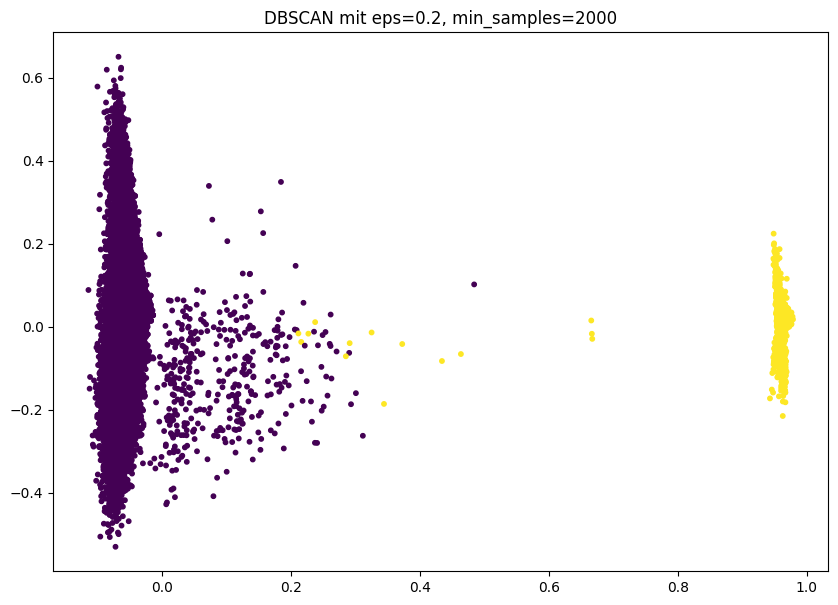

Parameter eps=0.2, min_samples=2000
{np.int64(-1): np.int64(48000), np.int64(0): np.int64(2669)}

----------------------------------------

Number of articles per DBSCAN cluster:
{np.int64(-1): np.int64(48000), np.int64(0): np.int64(2669)}

Cluster -1:
Examples:
                                               title       category
0  The Brands Queen Elizabeth, Prince Charles, an...      lifestyle
1                      50 Worst Habits For Belly Fat         health
2  The Cost of Trump's Aid Freeze in the Trenches...           news
3  I Was An NBA Wife. Here's How It Affected My M...         health
4  How to Get Rid of Skin Tags, According to a De...         health
5  Should NFL be able to fine players for critici...         sports
6  It's been Orlando's hottest October ever so fa...        weather
7  Chile: Three die in supermarket fire amid prot...           news
8  Best PS5 games: top PlayStation 5 titles to lo...  entertainment
9     How to report weather-related closings, delays     

In [15]:
# DBSCAN
best_eps = 0.2
best_samples = 2000


dbscan = DBSCAN(eps= best_eps, min_samples=best_samples, metric='cosine')
labels = dbscan.fit_predict(reduced_features)

plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f'DBSCAN mit eps={best_eps}, min_samples={best_samples}')
plt.show()

unique, counts = np.unique(labels, return_counts=True)
print(f'Parameter eps={best_eps}, min_samples={best_samples}')
print(dict(zip(unique, counts)))
print("\n" + "-"*40 + "\n")


# Count the number of articles in each DBSCAN cluster
unique_labels = np.unique(labels)  # labels = DBSCAN output labels
cluster_counts_dbscan = {label: (labels == label).sum() for label in unique_labels}

# Initialize dictionaries to store cluster information
cluster_examples_dbscan = {}
cluster_categories_dbscan = {}

# Iterate through each DBSCAN cluster
for cluster_id in unique_labels:
    cluster_data = news[labels == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples_dbscan[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories_dbscan[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per DBSCAN cluster:")
print(cluster_counts_dbscan)

for cluster_id in cluster_examples_dbscan:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples_dbscan[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories_dbscan[cluster_id])